# Out Results

In [1]:
#!pip install arviz
#!pip install pymc3
#!pip install fitter
#!pip install pydantic
#!pip install awswrangler
#!pip install statsd
#!pip install cachetools.ttl

In [2]:
#!pip freeze

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import arviz as az
import streamlit as st
%matplotlib inline

from ab_testing.constants import client_name, target_col
from ab_testing.distribution_fit.fit_distribution import FitDistribution
from ab_testing.predictions.produce_predictions import ProducePredictions
from ab_testing.data_acquisition.acquire_data import AcquireData, queries_dict

from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient

/Users/PeterNovak/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using Matus's code output and augmenting the ab_testing library to produc the sampled posterior distributions we are able to show the distribution of possible posteriors aka the distribution of the possible ab-test outcomes. The HDI's constructed show the 90% density of observed sample outcomes, if the two are non-overlaping the test can be seen as "conclusive" from a frequentist pov, aka the difference in ARPUs HDI does not include 0.

In [4]:
configure_offline_feature_store(
    workgroup="primary"
)

In [8]:
client_name = 'bingo_aloha'

initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
    queries_dict[client_name]
)

initial_data

2022-12-05 20:54:44,966 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


Missing STATSD_HOST and/or STATSD_PORT environment variables
DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:110.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:3198.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:36126069|c


In [21]:
start_date = initial_data.meta_date.min()
end_date = initial_data.meta_date.max()
start_fl = initial_data.first_login.min()
end_fl = initial_data.first_login.max()
spend_type = 0
client_name_small = client_name + '_small'

initial_data2 = FeatureStoreOfflineClient.run_athena_query_pandas(
    queries_dict[client_name_small],
    {
        'strt_date':str(start_date)[0:10],
        'end_date':str(end_date)[0:10],
        'strt_fl':str(start_fl)[0:10],
        'end_fl':str(end_fl)[0:10],
        'spend_type':spend_type,
    },
)

initial_data2

2022-12-05 20:59:13,397 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:135.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:2254.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:43704301|c


In [15]:
k = 1

client_map = ["bingo_aloha", "homw", "idle_mafia", "spongebob", "terra_genesis", "ultimex"]
client_name = client_map[k]
result = "total_wins_spend"


initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(queries_dict[client_name])
start_date = initial_data.meta_date.min()
end_date = initial_data.meta_date.max()
start_fl = initial_data.first_login.min()
end_fl = initial_data.first_login.max()
spend_type = 0

client_name_small = client_name + '_small'
initial_data2 = FeatureStoreOfflineClient.run_athena_query_pandas(
    queries_dict[client_name_small],
    {
        'strt_date':str(start_date)[0:10],
        'end_date':str(end_date)[0:10],
        'strt_fl':str(start_fl)[0:10],
        'end_fl':str(end_fl)[0:10],
        'spend_type':spend_type,
    },
)
fit_dist = FitDistribution(fname=f"{client_name}_distribution_fit.p")
best_distribution = fit_dist.fit(initial_data2.loc[initial_data2[result] > 0], result)

print(client_name)
best_distribution

2022-12-05 23:45:44,025 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c


2022-12-05 23:46:14,893 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_queue_ms:92.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:2458.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:13726552|c
DummyStatsClient._send unknown.athena_query_runs_total:1|c


ultimex


DummyStatsClient._send unknown.athena_query_queue_ms:122.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:1664.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:14987730|c


0    lognorm
1      expon
Name: distribution, dtype: object

bingo_aloha ->   lognorm, expon
homw ->          lognorm, expon
idle_mafia ->    lognorm, expon
spongebob -> na
terra_genesis -> na
ultimex ->       lognorm, expon

In [7]:
fit_dist = FitDistribution(fname=f"{client_name}_distribution_fit.p")
best_distribution = fit_dist.fit(initial_data.loc[initial_data[target_col] > 0], target_col)

result = ProducePredictions()
results_conversion = result.produce_results_conversion(initial_data)
results_revenue = result.produce_results_revenue(best_distribution, initial_data)

results_posterior_sample = result._produce_results_lognorm_dist_carry_value(initial_data)

Below set the creadibility mass (a bayesian term analogous to a confidence interval but with signifificantly differenet logic behind it (see refernece at end)). And construct the hdi threasholds using the arviz library. Results not neccessarily same because: Posterior Samples $\ne$ Observations

In [22]:
credMass = 0.9
post_sample_A      = results_posterior_sample[1]
post_sample_B      = results_posterior_sample[0]
post_sample_uplift = (post_sample_B - post_sample_A) / post_sample_A
hdi_A              = az.hdi(post_sample_A, hdi_prob=credMass)
hdi_B              = az.hdi(post_sample_B, hdi_prob=credMass)
hdi_diff           = az.hdi(post_sample_uplift, hdi_prob=credMass)

Create table 1:

In [23]:
output_df = pd.DataFrame(columns=["Metric", "Conversion", "ARPU"])
output_df["Metric"] = ["P( P > C)", "E( loss | P > C)", "E( loss | C > P)"]
output_df["Conversion"] = [
    "%.4f%%" % (results_conversion[0]["prob_being_best"] * 100),
    "%.4f%%" % (results_conversion[0]["expected_loss"] * 100),
    "%.4f%%" % (results_conversion[1]["expected_loss"] * 100),
]
output_df["Revenue"] = [
    "%.4f%%" % (results_revenue[0]["prob_being_best"] * 100),
    "%.4f%%" % (results_revenue[0]["expected_loss"] * 100),
    "%.4f%%" % (results_revenue[1]["expected_loss"] * 100),
]
output_df.set_index('Metric')

,Conversion,Revenue
Metric,,
P( P > C),4.0600%,7.5050%
E( loss | P > C),0.1586%,8.6180%
E( loss | C > P),0.0015%,0.2050%


Create table 2:

In [24]:
output_df2 = pd.DataFrame(columns=["Metric", "Control", "Personalised", "Personalised-Control"])
output_df2["Metric"] = ["sample size", "conversion", "ARPU", "ARPPU", "95% HDI"]
output_df2["Control"] = [
    "%d" % (results_revenue[1]['totals']),
    "%.2f%%" % (results_conversion[1]['positive_rate'] * 100),
    "%.4f€" % (results_revenue[1]['avg_values']),
    "%.4f€" % (results_revenue[1]['avg_positive_values']),
    "[%.4f€, %.4f€]" % (hdi_A[0], hdi_A[1]),
]
output_df2["Personalised"] = [
    "%d" % (results_revenue[0]['totals']),
    "%.2f%%" % (results_conversion[0]['positive_rate'] * 100),
    "%.4f€" % (results_revenue[0]['avg_values']),
    "%.4f€" % (results_revenue[0]['avg_positive_values']),
    "[%.4f€, %.4f€]" % (hdi_B[0], hdi_B[1]),
]
output_df2["Personalised-Control"] = [
    np.NAN,
    "%.2f%%" % ((results_conversion[0]['positive_rate'] - results_conversion[1]['positive_rate']) * 100),
    "%.4f€" % (results_revenue[0]['avg_values'] - results_revenue[1]['avg_values']),
    "%.4f€" % (results_revenue[0]['avg_positive_values'] - results_revenue[1]['avg_positive_values']),
    "[%.4f€, %.4f€]" % (hdi_diff[0], hdi_diff[1]),
]
output_df2.set_index('Metric')

,Control,Personalised,Personalised-Control
Metric,,,
sample size,168914,72731,NaN
conversion,4.24%,4.08%,-0.16%
ARPU,1.2649€,1.2196€,-0.0453€
ARPPU,29.8535€,29.8975€,0.0440€
95% HDI,"[1.1039€, 1.2153€]","[0.9993€, 1.1546€]","[-0.1536€, 0.0063€]"


Create plot 1:

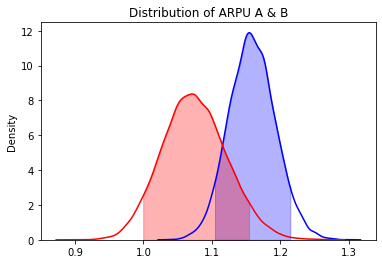

In [25]:
fig = plt.figure.Figure()
ax = fig.add_subplot(111)
#fig = plt.pyplot.figure(figsize=(12, 6))

fig_temp = sns.kdeplot(post_sample_A, color="blue")
fig_temp = sns.kdeplot(post_sample_B, color="red")
l1 = fig_temp.lines[0]
l2 = fig_temp.lines[1]
x1 = l1.get_xydata()[:,0]
x2 = l2.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
y2 = l2.get_xydata()[:,1]
x1_new = x1[[all(tup) for tup in zip(list(x1 >= hdi_A[0]), list(x1 <= hdi_A[1]))]]
x2_new = x2[[all(tup) for tup in zip(list(x2 >= hdi_B[0]), list(x2 <= hdi_B[1]))]]
y1_new = y1[[all(tup) for tup in zip(list(x1 >= hdi_A[0]), list(x1 <= hdi_A[1]))]]
y2_new = y2[[all(tup) for tup in zip(list(x2 >= hdi_B[0]), list(x2 <= hdi_B[1]))]]
plt.pyplot.fill_between(x1_new, y1_new, color="blue", alpha=0.3)
plt.pyplot.fill_between(x2_new, y2_new, color="red", alpha=0.3)
plt.pyplot.title('Distribution of ARPU A & B')
ax.legend(labels=['Control','Personalised'])
plt.pyplot.show()

Create plot 2:

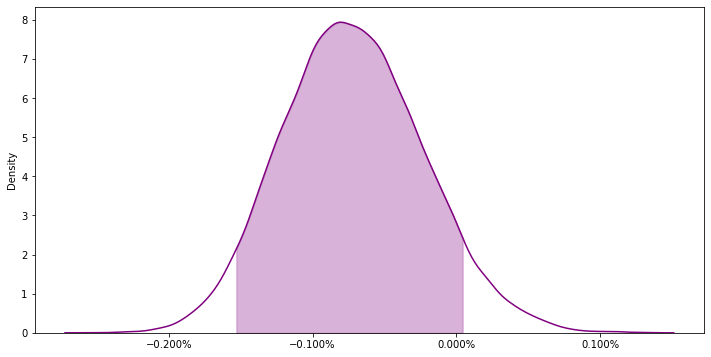

In [26]:
fig = plt.pyplot.figure(figsize=(12, 6))

fig_temp2 = sns.kdeplot(post_sample_uplift, color="purple")
l = fig_temp2.lines[0]
x = l.get_xydata()[:,0]
y = l.get_xydata()[:,1]
x_new = x[[all(tup) for tup in zip(list(x >= hdi_diff[0]), list(x <= hdi_diff[1]))]]
y_new = y[[all(tup) for tup in zip(list(x >= hdi_diff[0]), list(x <= hdi_diff[1]))]]
fig_temp2.xaxis.set_major_formatter(plt.ticker.PercentFormatter())
plt.pyplot.fill_between(x_new, y_new, color="purple", alpha=0.3)
plt.pyplot.show()

## Quick and basic anonimisation of Bingo Aloha data to be put onto git:

In [66]:
import random
df = pd.read_parquet("./bingo_aloha_data.p")

dictionary = dict(
    zip(
        set(df.user_id),
        list(set([random.randrange(10**5,10**6) for a in np.arange(len(set(df.user_id))*1.3)]))[:len(set(df.user_id))]
    )
)

# now we will match the old ids from the dataset to the new ones
df['user_id'] = df['user_id'].map(dictionary)
df['test_group'][df['test_group'] == 'C'] = 'T'
df['test_group'][df['test_group'] == 'P'] = 'C'
df['test_group'][df['test_group'] == 'T'] = 'P'
df = df.sort_values(['user_id'], ascending = False)
df.sample(100000, random_state = 3).to_parquet("./test_data.p")